<a href="https://colab.research.google.com/github/Orangefox76200/CapsNet-LSTM/blob/main/CapsNet_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Time Series Forecasting Using A Hybrid CapsNet-LSTM Architecture: Using real world data (DJIA Index)

DJIA Index dataset contains data of the daily DJIA Index prices recorded from Jan 1st, 2010 to Dec 31st, 2019. In addition to be using Tensorflow's layers for processing sequence data such as LSTMs we will also intergrate Capsule Network in our proposed hybrid architecture to improve the model's performance.

Let's get started!

In [1]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 45.2 MB/s 


In [2]:
import keras.backend as K
import tensorflow as tf
import keras
import keras_tuner
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
# from keras.callbacks import *
from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging


import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [3]:
# Set seed
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [4]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
print(tf.__version__)

2.8.2


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [7]:
from google.colab import drive
drive.mount ('gdrive')
DJIA_raw = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/DJIA.xlsx')
DJIA_raw

Mounted at gdrive


,Date,Open,High,Low,Close,Volume
0,"Jan 04, 2010",10430.69,10604.97,10430.69,10583.96,179780000
1,"Jan 05, 2010",10584.56,10584.56,10522.52,10572.02,188540000
2,"Jan 06, 2010",10564.72,10594.99,10546.55,10573.68,186040000
3,"Jan 07, 2010",10571.11,10612.37,10505.21,10606.86,217390000
4,"Jan 08, 2010",10606.40,10619.40,10554.33,10618.19,172710000
...,...,...,...,...,...,...
2511,"Dec 24, 2019",28572.57,28576.80,28503.21,28515.45,86150000
2512,"Dec 26, 2019",28539.46,28624.10,28535.15,28621.39,155970000
2513,"Dec 27, 2019",28675.34,28701.66,28608.98,28645.26,182280000
2514,"Dec 30, 2019",28654.76,28664.69,28428.98,28462.14,181600000


In [8]:
series = DJIA_raw.iloc[:,4]

In [9]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

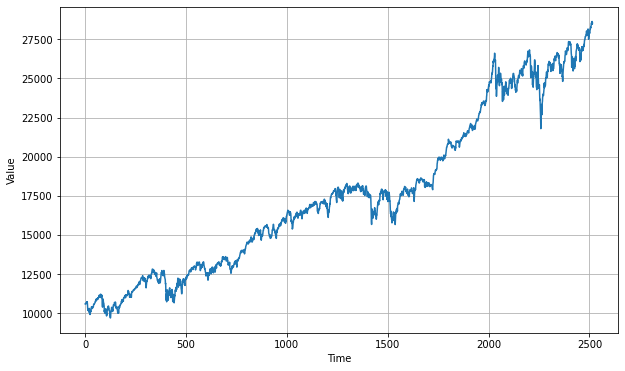

In [11]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int((len(series)-150)*0.8)
    WINDOW_SIZE = 250
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 60

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

The `train_val_split` and `windowed_dataset` functions:

In [12]:
def train_val_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:-150]
    series_valid = series[time_step:-150]
    time_test = time[-150:]
    series_test = series[-150:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test

# Split the dataset
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_test_split(G.TIME, G.SERIES)

min-max normalization:

In [13]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [14]:
series_norm = min_max_normalization(G.SERIES)

In [15]:
series_train_norm = series_norm[:G.SPLIT_TIME]
series_valid_norm = series_norm[G.SPLIT_TIME:-150]
series_test_norm = series_norm[-150:]

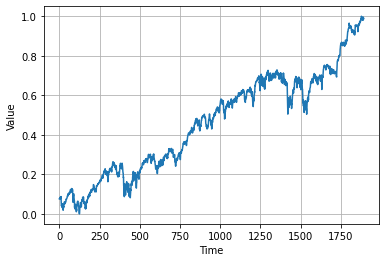

In [16]:
plot_series(time_train, series_train_norm)

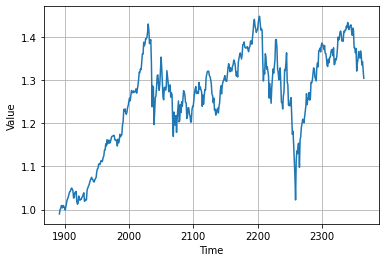

In [17]:
plot_series(time_valid, series_valid_norm)

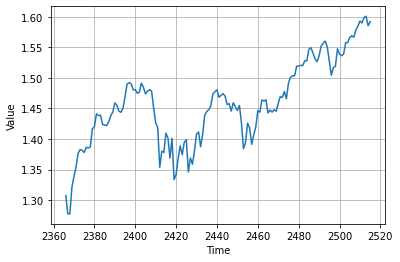

In [18]:
plot_series(time_test, series_test_norm)

In [19]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer) 
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [20]:
# create val_set without using shuffle method.
def windowed_dataset_noshuffle(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

val_set = windowed_dataset_noshuffle(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

In [21]:
train_val_set = windowed_dataset(series_norm[0:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Compiling the model


### Defining the model architecture (CapsNet-LSTM)


In [22]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [43]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

In [24]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [27]:
input_shape = (G.WINDOW_SIZE, 1)

In [28]:
# Prepare callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

In [29]:
K.clear_session()

### Tune hyper-parameters

In [53]:
def build_CapsNet_LSTM(hp):
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=hp.Int('Conv1_units', 256, 1024, 256), kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
    conv1d_2 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='causal',name = 'conv1d_2')(conv1d_1)

    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 64, 8))(conv1d_2)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = hp.Int('dim_capsule', 256, 1024, 256), routings = hp.Int('routings', 3, 5, 1)))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(hp.Int('lstm_units', 150, 300, 50))(digit_caps)

    # Dropout  
    dropout = tf.keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, 0.1))(lstm)

    # Dense layer
    dense1 = tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, 10), activation="relu")(dropout)
    dense2 = tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, 5), activation="relu")(dense1)
    output = tf.keras.layers.Dense(1)(dense2)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [54]:
build_CapsNet_LSTM(keras_tuner.HyperParameters())

tuner_capsnet_lstm = keras_tuner.Hyperband(
    hypermodel=build_CapsNet_LSTM,
    objective="val_mae",
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    seed = 1,
    directory='/content/gdrive/MyDrive/Tuner',
    project_name='capsnet_lstm_2',
    overwrite = True)

tuner_capsnet_lstm.search(train_set, epochs=50, validation_data=val_set, callbacks=[stop_early])

tuner_capsnet_lstm.results_summary()

# Get the top 5 hyperparameters.
best_hps_capsnet_lstm = tuner_capsnet_lstm.get_best_hyperparameters(5)

Trial 90 Complete [00h 02m 38s]
val_mae: 0.06437382102012634

Best val_mae So Far: 0.0290041696280241
Total elapsed time: 02h 13m 58s
Results summary
Results in /content/gdrive/MyDrive/Tuner/capsnet_lstm_2
Showing 10 best trials
Trial summary
Hyperparameters:
Conv1_units: 256
dim_capsule: 1024
routings: 3
lstm_units: 200
dropout: 0.30000000000000004
dense1_units: 40
dense2_units: 10
lr: 0.00028406107009737317
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0044
Score: 0.0290041696280241
Trial summary
Hyperparameters:
Conv1_units: 512
dim_capsule: 768
routings: 5
lstm_units: 200
dropout: 0.2
dense1_units: 40
dense2_units: 10
lr: 0.00011465640987948183
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.029817240312695503
Trial summary
Hyperparameters:
Conv1_units: 768
dim_capsule: 1024
routings: 5
lstm_units: 200
dropout: 0.30000000000000004
dense1_units: 50
dense2_units: 5
lr: 0.00010295621606198

In [ ]:
# Prepare check point
# capsnet_lstm_checkpoint_filepath = '/content/gdrive/MyDrive/model_checkpoint/capsnet_lstm.hdf5'
# model_checkpoint_callback_capsnet_lstm = tf.keras.callbacks.ModelCheckpoint(
#    filepath=capsnet_lstm_checkpoint_filepath,
#    save_weights_only=True,
#    monitor='mae',
#    mode='min',
#    save_best_only=True)

In [55]:
# Build the model with the best hp.
with strategy.scope():
  capsnet_lstm = build_CapsNet_LSTM(best_hps_capsnet_lstm[0])
# Fit with the entire dataset.
capsnet_lstm.fit(train_val_set, epochs=200)

Epoch 1/200
67/67 [==============================] - 27s 267ms/step - loss: 0.0182 - mae: 0.1700
Epoch 2/200
67/67 [==============================] - 14s 212ms/step - loss: 0.0542 - mae: 0.2576
Epoch 3/200
67/67 [==============================] - 14s 213ms/step - loss: 0.0046 - mae: 0.0793
Epoch 4/200
67/67 [==============================] - 14s 213ms/step - loss: 0.0038 - mae: 0.0698
Epoch 5/200
67/67 [==============================] - 14s 212ms/step - loss: 0.0025 - mae: 0.0559
Epoch 6/200
67/67 [==============================] - 14s 213ms/step - loss: 0.0019 - mae: 0.0485
Epoch 7/200
67/67 [==============================] - 14s 213ms/step - loss: 0.0017 - mae: 0.0456
Epoch 8/200
67/67 [==============================] - 14s 212ms/step - loss: 0.0014 - mae: 0.0396
Epoch 9/200
67/67 [==============================] - 14s 213ms/step - loss: 0.0014 - mae: 0.0393
Epoch 10/200
67/67 [==============================] - 14s 212ms/step - loss: 0.0013 - mae: 0.0380
Epoch 11/200
67/67 [=========

In [34]:
# Load the best parameters.
# capsnet_lstm.load_weights(capsnet_lstm_checkpoint_filepath)

In [56]:
print(capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 256)          768       
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 512)          262656    
                                                                 
 reshape_1 (Reshape)         (None, 250, 64, 8)        0         
                                                                 
 lambda_1 (Lambda)           (None, 250, 64, 8)        0         
                                                                 
 time_distributed_1 (TimeDis  (None, 250, 1024)        524288    
 tributed)                                                       
                                                      

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



### Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

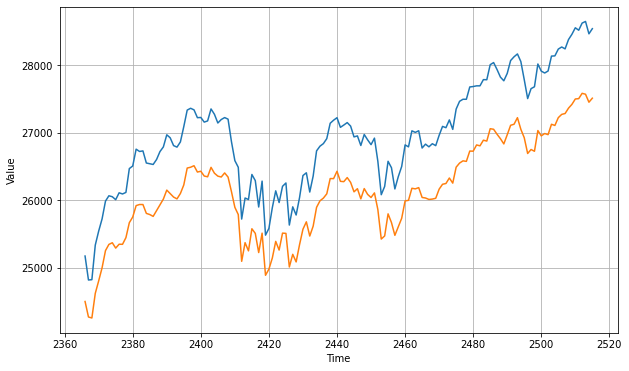

In [57]:
# Compute the forecast for all the series
capsnet_lstm_forecast = model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_capsnet_lstm = capsnet_lstm_forecast[-150:]

# Reverse normalization
series_test_hat_capsnet_lstm = reverse_normalization(series_test_hat_capsnet_lstm)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat_capsnet_lstm)

In [58]:
mse_capsnet_lstm, mae_capsnet_lstm = compute_metrics(series_test, series_test_hat_capsnet_lstm)

print(f"mse: {mse_capsnet_lstm:.2f}, mae: {mae_capsnet_lstm:.2f} for forecast")

mse: 682508.56, mae: 819.11 for forecast


In [59]:
# Save model
capsnet_lstm.save('/content/gdrive/MyDrive/Saved_models/capsnet_lstm_2.h5')

## Baseline (LSTM, CNN-LSTM)

### LSTM

In [39]:
def build_LSTM(hp):
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(hp.Int('lstm_units', 100, 300, 50), input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, 10), activation="relu"),
          tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, 5), activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [40]:
build_LSTM(keras_tuner.HyperParameters())

tuner_lstm = keras_tuner.Hyperband(
    hypermodel=build_LSTM,
    objective="val_mae",
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    seed = 1,
    directory='/content/gdrive/MyDrive/Tuner',
    project_name="lstm",
    overwrite=True)

tuner_lstm.search(train_set, epochs=50, validation_data=val_set,callbacks=[stop_early])

tuner_lstm.results_summary()

# Get the top 5 hyperparameters.
best_hps_lstm = tuner_lstm.get_best_hyperparameters(5)



Trial 90 Complete [00h 01m 47s]
val_mae: 0.02772478573024273

Best val_mae So Far: 0.023197626695036888
Total elapsed time: 00h 46m 09s
Results summary
Results in /content/gdrive/MyDrive/Tuner/lstm
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 200
dense1_units: 30
dense2_units: 15
lr: 0.0006201914963139159
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.023197626695036888
Trial summary
Hyperparameters:
lstm_units: 300
dense1_units: 30
dense2_units: 15
lr: 0.0009452767099282696
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.023722941055893898
Trial summary
Hyperparameters:
lstm_units: 200
dense1_units: 50
dense2_units: 10
lr: 0.0008960175671873151
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.02385629713535309
Trial summary
Hyperparameters:
lstm_units: 200
dense1_units: 20
dense2_units: 15
lr: 0.00036151371126048177
tuner/e

In [41]:
# Prepare check point
# lstm_checkpoint_filepath = '/content/gdrive/MyDrive/model_checkpoint/lstm.hdf5'
# model_checkpoint_callback_lstm = tf.keras.callbacks.ModelCheckpoint(
#    filepath=lstm_checkpoint_filepath,
#    save_weights_only=True,
#    monitor='mae',
#    mode='min',
#    save_best_only=True)

In [42]:
# Build the model with the best hp.
with strategy.scope():
  lstm = build_LSTM(best_hps_lstm[0])
# Fit with the entire dataset.
lstm.fit(train_val_set, epochs=200)

Epoch 1/200
67/67 [==============================] - 8s 49ms/step - loss: 0.0079 - mae: 0.1038
Epoch 2/200
67/67 [==============================] - 2s 29ms/step - loss: 0.0335 - mae: 0.2005
Epoch 3/200
67/67 [==============================] - 2s 30ms/step - loss: 0.0143 - mae: 0.1325
Epoch 4/200
67/67 [==============================] - 2s 29ms/step - loss: 0.0100 - mae: 0.1047
Epoch 5/200
67/67 [==============================] - 2s 29ms/step - loss: 0.0075 - mae: 0.1000
Epoch 6/200
67/67 [==============================] - 2s 29ms/step - loss: 0.0046 - mae: 0.0756
Epoch 7/200
67/67 [==============================] - 2s 29ms/step - loss: 0.0032 - mae: 0.0626
Epoch 8/200
67/67 [==============================] - 2s 29ms/step - loss: 0.0014 - mae: 0.0410
Epoch 9/200
67/67 [==============================] - 2s 29ms/step - loss: 4.1443e-04 - mae: 0.0218
Epoch 10/200
67/67 [==============================] - 2s 29ms/step - loss: 3.3659e-04 - mae: 0.0196
Epoch 11/200
67/67 [=====================

In [43]:
# lstm.load_weights(lstm_checkpoint_filepath)

In [44]:
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_3 (Dense)             (None, 30)                6030      
                                                                 
 dense_4 (Dense)             (None, 15)                465       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 168,111
Trainable params: 168,111
Non-trainable params: 0
_________________________________________________________________
None


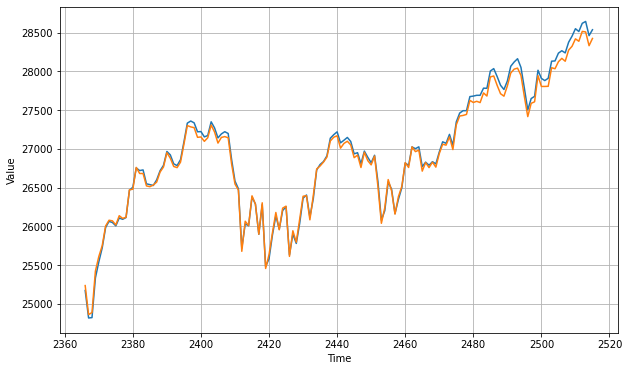

In [46]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_lstm = lstm_forecast[-150:]
series_test_hat_lstm = reverse_normalization(series_test_hat_lstm)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat_lstm)

In [47]:
mse_lstm, mae_lstm = compute_metrics(series_test, series_test_hat_lstm)

print(f"mse: {mse_lstm:.2f}, mae: {mae_lstm:.2f} for forecast")

mse: 3516.02, mae: 48.71 for forecast


In [45]:
# Save model
lstm.save("/content/gdrive/MyDrive/Saved_models/lstm.h5")

### CNN-LSTM

In [28]:
def build_CNN_LSTM(hp):
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=hp.Int('Conv_units', 256, 1024, 256), kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(hp.Int('lstm_units', 100, 300, 50)),
          tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, step = 10), activation="relu"),
          tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, step = 5), activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [31]:
build_CNN_LSTM(keras_tuner.HyperParameters())

tuner_cnn_lstm = keras_tuner.Hyperband(
    hypermodel=build_CNN_LSTM,
    objective="val_mae",
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    seed = 1,
    directory='/content/gdrive/MyDrive/Tuner',
    project_name="cnn-lstm",
    overwrite=True)


tuner_cnn_lstm.search(train_set, epochs=50, validation_data=val_set, callbacks=[stop_early])

tuner_cnn_lstm.results_summary()

# Get the top 5 hyperparameters.
best_hps_cnn_lstm = tuner_cnn_lstm.get_best_hyperparameters(5)

Trial 90 Complete [00h 02m 19s]
val_mae: 0.01555017288774252

Best val_mae So Far: 0.014640899375081062
Total elapsed time: 01h 05m 20s
Results summary
Results in /content/gdrive/MyDrive/Tuner/cnn-lstm
Showing 10 best trials
Trial summary
Hyperparameters:
Conv_units: 256
lstm_units: 200
dense1_units: 30
dense2_units: 10
lr: 0.0015681643294594688
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.014640899375081062
Trial summary
Hyperparameters:
Conv_units: 512
lstm_units: 250
dense1_units: 30
dense2_units: 5
lr: 0.0012650614556534965
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.01555017288774252
Trial summary
Hyperparameters:
Conv_units: 768
lstm_units: 250
dense1_units: 20
dense2_units: 15
lr: 0.0011971901340926848
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0040
Score: 0.01649758405983448
Trial summary
Hyperparameters:
Conv_units: 256
lstm_units: 300
dense1_units: 50
dense2_u

In [ ]:
# Prepare check point
# cnn_lstm_checkpoint_filepath = '/content/gdrive/MyDrive/model_checkpoint/cnn_lstm_checkpoint.hdf5'
# model_checkpoint_callback_cnn_lstm = tf.keras.callbacks.ModelCheckpoint(
#    filepath=cnn_lstm_checkpoint_filepath,
#    save_weights_only=True,
#    monitor='mae',
#    mode='min',
#    save_best_only=True)

In [34]:
# Build the model with the best hp.
with strategy.scope():
  cnn_lstm = build_CNN_LSTM(best_hps_cnn_lstm[0])
# Fit with the entire dataset.
cnn_lstm.fit(train_val_set, epochs=200)

Epoch 1/200
67/67 [==============================] - 11s 74ms/step - loss: 0.0056 - mae: 0.0803
Epoch 2/200
67/67 [==============================] - 3s 49ms/step - loss: 0.0032 - mae: 0.0562
Epoch 3/200
67/67 [==============================] - 3s 49ms/step - loss: 0.0014 - mae: 0.0378
Epoch 4/200
67/67 [==============================] - 3s 48ms/step - loss: 9.9701e-04 - mae: 0.0306
Epoch 5/200
67/67 [==============================] - 3s 49ms/step - loss: 0.0010 - mae: 0.0360
Epoch 6/200
67/67 [==============================] - 3s 48ms/step - loss: 0.0013 - mae: 0.0422
Epoch 7/200
67/67 [==============================] - 3s 49ms/step - loss: 0.0014 - mae: 0.0424
Epoch 8/200
67/67 [==============================] - 3s 49ms/step - loss: 5.3257e-04 - mae: 0.0264
Epoch 9/200
67/67 [==============================] - 3s 49ms/step - loss: 3.4636e-04 - mae: 0.0201
Epoch 10/200
67/67 [==============================] - 3s 50ms/step - loss: 1.8975e-04 - mae: 0.0135
Epoch 11/200
67/67 [============

In [ ]:
# cnn_lstm.load_weights(cnn_lstm_checkpoint_filepath)

In [35]:
print(cnn_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 250, 256)          768       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 256)         0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 200)               365600    
                                                                 
 dense_3 (Dense)             (None, 30)                6030      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                      

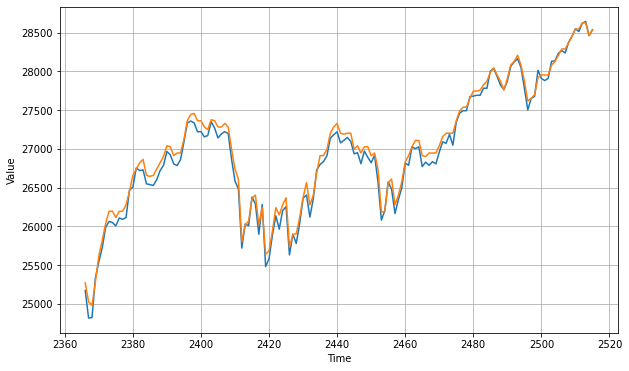

In [37]:
# Compute the forecast for all the series
cnn_lstm_forecast = model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_cnn_lstm = cnn_lstm_forecast[-150:]
series_test_hat_cnn_lstm = reverse_normalization(series_test_hat_cnn_lstm)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat_cnn_lstm)

In [38]:
mse_cnn_lstm, mae_cnn_lstm = compute_metrics(series_test, series_test_hat_cnn_lstm)

print(f"mse: {mse_cnn_lstm:.2f}, mae: {mae_cnn_lstm:.2f} for forecast")

mse: 8637.47, mae: 78.72 for forecast


In [36]:
# Save model
cnn_lstm.save('/content/gdrive/MyDrive/Saved_models/cnn_lstm.h5')

## Camparison

Compare our proposed Capsnet-LSTM with LSTM and CNN-LSTM

### Three forecasting results in one figure:

### Compare the rmse, mae mape